In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt 
import shapely
from shapely.geometry import LineString, Point, Polygon
import time
from scipy import spatial
# http://mathster.com/graphpaper/graphpaperjs/

In [ ]:
def nb_show(title,img) :
    plt.imshow(img, cmap="gray"),plt.title(title)
    # plt.xticks([]),plt.yticks([])
    plt.show()

# TAKING BACKGROUND PHOTO

In [5]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_BUFFERSIZE, 0)
cam.set(cv2.CAP_PROP_FORMAT, cv2.CV_32F)
WIDTH = 1920
HEIGHT = 1080
cam.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)

True

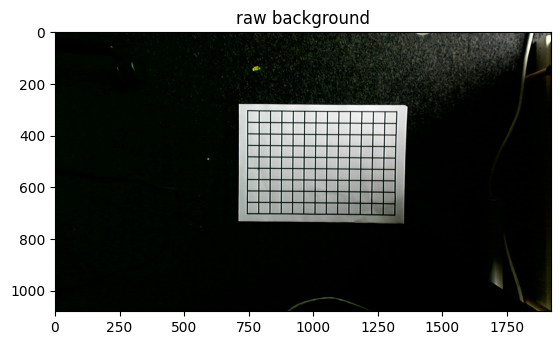

True

In [12]:
mean_iter=5
avg = []

for i in range(mean_iter):
   time.sleep(0.1)
   if cam.isOpened(): 
      ret, a = cam.read()
      avg.append(a)
      if ret:
         pass 
      else:
         print("frame not captured")
   else:
      print("cannot open camera")
   
   if i == 0:
      dst = avg[i]
   else:
      alpha = 1.0/(i + 1)
      beta = 1.0 - alpha
      dst = cv2.addWeighted(avg[i], alpha, dst, beta, 0.0)

background_raw = dst

nb_show("raw background",cv2.cvtColor(background_raw, cv2.COLOR_RGB2BGR))
cv2.imwrite('./content/background.jpg',background_raw)

# CROP

## CODE

In [13]:
def get_bounding_box(img) :
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(img_gray,(5,5),0)
  # ret2,th2 = cv2.threshold(blur,100,120,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

  edges = cv2.Canny(th2,150,160,L2gradient = True)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  c = max(contours, key = cv2.contourArea)
  x,y,w,h = cv2.boundingRect(c)
  # cpy = edges.copy()
  # cv2.rectangle(cpy, (x, y), (x + w, y + h), (255,0,0), 4)
  # nb_show("background cropped",cpy)
  return cv2.boundingRect(c)

def crop(img_in, box):
  x,y,w,h = box
  img_out = img_in[y:y+h,x:x+w]
  return img_out

In [29]:

# first crop 
auto_bounding_box = get_bounding_box(background_raw)
background_auto_crop = crop(background_raw,auto_bounding_box)

# second crop 
x = -20
y = -10
w = 620
h = 440
manual_bounding_box = (x,y,w,h)
background_manual_crop = crop(background_auto_crop,manual_bounding_box)

final_bounding_box = (auto_bounding_box[0]+manual_bounding_box[0] , auto_bounding_box[1]+manual_bounding_box[1] , manual_bounding_box[2] , manual_bounding_box[3])


background = crop(background_raw,final_bounding_box)
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)


## OUTPUT

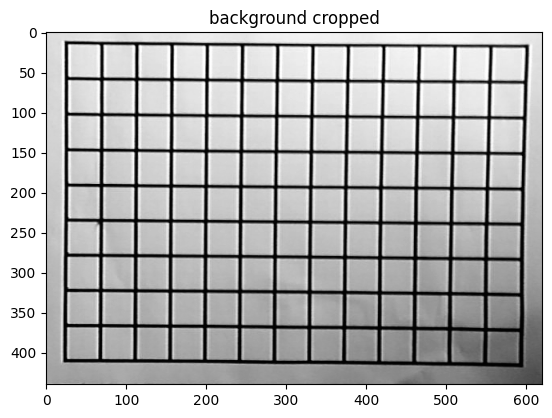

In [30]:
nb_show("background cropped",background)

## THRESHOLD

### CODE

In [31]:
blur = cv2.GaussianBlur(background,(3,3),0)

# 3x3 array for edge detection
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

## TODO: Create and apply a Sobel x operator
sobel_x = np.array([[ -1, 0, 1], 
                   [ -2, 0, 2], 
                   [ -1, 0, 1]])

edge_detection = np.array([[ 0.0, -1, 0], 
                        [ -1, 4, -1], 
                        [ 0, -1, 0]])

kernel3 = np.array([[0, -1,  0],
                   [-1,  5, -1],
                    [0, -1,  0]])

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  https://alyxion.github.io/Udacity_IntroToSelfDrivingCarsNd/8_1_Intro_Mini_Projects/41_Finding%20Edges%20and%20Custom%20Kernels.html
sobely = cv2.filter2D(blur, -1, sobel_y)

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
sobelx = cv2.filter2D(blur, -1, sobel_x)

sobelxy = cv2.bitwise_not(cv2.addWeighted(sobely, 0.5, sobelx, 0.5, 0))

# Otsu's thresholding
ret2,th2 = cv2.threshold(sobelxy,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blurred = cv2.GaussianBlur(sobelxy,(3,3),0)
ret3,th3 = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edges = cv2.Canny(th3, 50, 200)

### OUTPUT

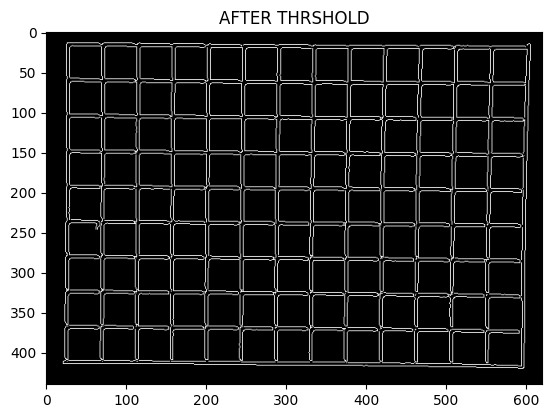

In [32]:
nb_show("AFTER THRSHOLD",edges)

# EXTRACT GRID

### HoughBundler

In [33]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)


    def denoise(self, noisy):
      kernel1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]], np.uint8)
      kernel2 = np.array([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]], np.uint8)
      hitormiss1 = cv2.morphologyEx(noisy, cv2.MORPH_ERODE, kernel1)
      hitormiss2 = cv2.morphologyEx(cv2.bitwise_not(noisy), cv2.MORPH_ERODE, kernel2)
      hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2)
      hitormiss_comp = cv2.bitwise_not(hitormiss) 
      clean = cv2.bitwise_and(noisy, noisy, mask=hitormiss_comp)
      return clean

    def preprocessing(self, img_in):
      blur = cv2.GaussianBlur(img_in,(3,3),0)
      threshold = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,2)
      threshold = cv2.bitwise_not(threshold)
      threshold = self.denoise(threshold)
      kernel = np.ones((3,3))
      img_out = cv2.dilate(threshold, kernel, iterations=1)
      return img_out


def linesSort(lines):
  lines_v = []
  lines_h = []
  delta_x = 50
  delta_y = 50

  for line in lines:
      x1, y1, x2, y2 = line[0]

      if x2 > x1 - delta_x and x2 < x1 + delta_x :
        lines_h.append(line)

      if y2 > y1 - delta_y and y2 < y1 + delta_y :
        lines_v.append(line)
  
  return lines_h,lines_v

def get_equation(p1, p2):
  A = (p1[1] - p2[1])
  B = (p2[0] - p1[0])
  C = (p1[0]*p2[1] - p2[0]*p1[1])
  return A, B, -C

def intersection(L1, L2):
  D  = L1[0] * L2[1] - L1[1] * L2[0]
  Dx = L1[2] * L2[1] - L1[1] * L2[2]
  Dy = L1[0] * L2[2] - L1[2] * L2[0]
  if D != 0:
    x = Dx / D
    y = Dy / D
    return int(x),int(y)
  else:
    return False

def closest_node(node, nodes):
  nodes = np.asarray(nodes)
  deltas = nodes - node
  dist_2 = np.einsum('ij,ij->i', deltas, deltas)
  return np.argmin(dist_2)

def lines_to_grid (lines):
  lines_h,lines_v = linesSort(lines)
  grid_list = []
  for lineh in lines_h :
    for linev in lines_v :
      L1 = get_equation([lineh[0][0],lineh[0][1]] ,[lineh[0][2],lineh[0][3]])
      L2 = get_equation([linev[0][0],linev[0][1]] ,[linev[0][2],linev[0][3]])
      R = intersection(L1, L2)
      # print(R)
      grid_list.append(R)
  nodes = np.array(sorted(grid_list , key=lambda k: [k[0], k[1]]))
  reshaped = np.reshape(nodes,(len(lines_h),len(lines_v),2)).astype(int)
  return reshaped

## CODE

In [34]:
# Create HoughBundler instance to process lines given by cv2.HoughLinesP()
bundler = HoughBundler(min_distance=5,min_angle=5)
#background_processed = bundler.preprocessing(background)
lines = cv2.HoughLinesP(cv2.bitwise_not(th3),rho = 1,theta = 1*np.pi/180,threshold = 80,minLineLength = 100,maxLineGap = 50)
lines = bundler.process_lines(lines)



# Convert processed lines to a point matrix
points_matrix = lines_to_grid(lines)
print(points_matrix.shape)


(14, 10, 2)


## RESULT

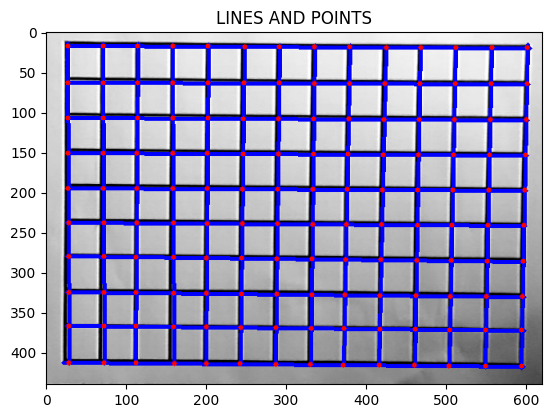

(14, 10, 2)


In [74]:
img_out = cv2.cvtColor(background.copy(),cv2.COLOR_GRAY2RGB)
for line in lines:
    cv2.line(img_out,(line[0][0],line[0][1]),(line[0][2],line[0][3]),(0,0,255),3)

for i in range(points_matrix.shape[0]):
  for j in range(points_matrix.shape[1]):
    cv2.circle(img_out, points_matrix[i][j][:] , radius=3, color=(255, 0, 0), thickness=-1)

nb_show("LINES AND POINTS",img_out)
# time.sleep(0.5)
print(points_matrix.shape)


# TAKING FRAME PHOTO

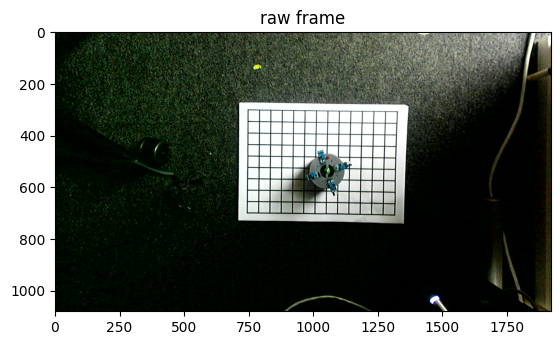

In [402]:
if cam.isOpened():
   ret, frame_raw = cam.read()
   if ret:
      nb_show("raw frame",cv2.cvtColor(frame_raw, cv2.COLOR_RGB2BGR))
      cv2.imwrite('./content/frame.jpg',frame_raw)
   else:
      print("frame not captured")
else:
   print("cannot open camera")

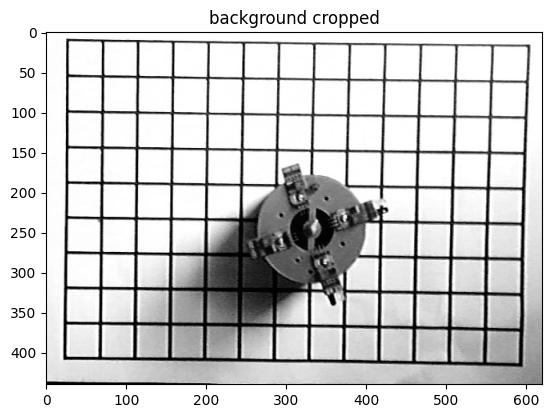

In [403]:
frame_color = crop(frame_raw,final_bounding_box)
frame = cv2.cvtColor(frame_color, cv2.COLOR_BGR2GRAY)
nb_show("background cropped",frame)

In [404]:
def get_centroids(img) :
    cXlist=[]
    cYlist=[]
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
    for c in sorted_contours:
        # calculate moments for each contour
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cXlist.append(cX)
            cYlist.append(cY)
        else:
            pass # do nothing, centroid value is not usable
    return cXlist,cYlist

In [405]:
# RED BLOB EXTRACTION
kernel = np.ones((2,2))
frame_red_extract = np.copy(frame_color)
frame_red_extract[(frame_red_extract[:,:,0] > 50) | (frame_red_extract[:,:,1]  > 50) | (frame_red_extract[:, :, 2] < 60) ]=0
red_blobs = cv2.cvtColor(frame_red_extract, cv2.COLOR_BGR2GRAY)
ret2,red_blobs_th = cv2.threshold(red_blobs,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
red_blobs_erode = cv2.erode(red_blobs_th,kernel)
red_blobs_dilate = cv2.dilate(red_blobs_erode,kernel,iterations=2)
cXlistR,cYlistR = get_centroids(red_blobs_dilate)
red_x, red_y = (cXlistR[0], cYlistR[0])


# GREEN BLOB EXTRACTION
frame_green_extract = np.copy(frame_color)
frame_green_extract[(frame_green_extract[:,:,0] > 45) | (frame_green_extract[:,:,1]  < 60) | (frame_green_extract[:, :, 2] > 40) ]=0
green_blobs = cv2.cvtColor(frame_green_extract, cv2.COLOR_BGR2GRAY)
ret2,green_blobs_th = cv2.threshold(green_blobs,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
green_blobs_erode = cv2.erode(green_blobs_th,np.ones((1,1)))
# green_blobs_erode = green_blobs_th
green_blobs_dilate = cv2.dilate(green_blobs_erode,kernel,iterations=2)
cXlistG,cYlistG = get_centroids(green_blobs_dilate)
green_x, green_y = (cXlistG[0],cYlistG[0])
# nb_show("leds extract",red_blobs_dilate)

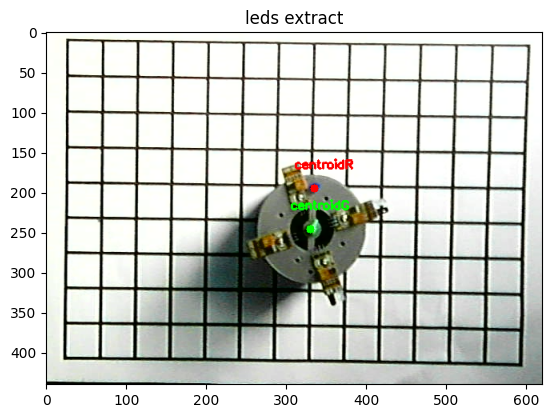

In [406]:
imge = np.copy(frame_color)
cv2.circle(imge, (red_x, red_y), 5, (255, 0, 0), -1)
cv2.putText(imge, "centroidR", (red_x - 25, red_y - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.circle(imge, (green_x, green_y), 5, (0, 255,0), -1)
cv2.putText(imge, "centroidG", (green_x - 25, green_y - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255,0), 2)
nb_show("leds extract",imge)

In [407]:
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return round(np.degrees(angle),2) 

red_led = Point(red_x, red_y)
green_led = Point(green_x, green_y)

# POSITION
spiderino_centroid =  (green_x, green_y)

# ANGLE 
angle_uncal = azimuth(green_led,red_led)

lines_h,lines_v = linesSort(lines)
a = []
for lineh in lines_h :
    # print(lineh)
    P1 = Point(lineh[0][0], lineh[0][1])
    P2 = Point(lineh[0][2], lineh[0][3])
    a.append(azimuth(P1,P2))

avg = round(np.average(a),2)
angle_cal = angle_uncal + avg

print("Uncalibrated angle (deg) :",angle_uncal)
print("Avg angle of vertical lines (deg) :",avg)
print("Calibrated angle (deg) :",angle_cal)

print("SPIDERINO :")
print(" - Position (x,y) =",spiderino_centroid)
print(" - Angle (deg) =",angle_cal)

Uncalibrated angle (deg) : 174.4
Avg angle of vertical lines (deg) : -0.65
Calibrated angle (deg) : 173.75
SPIDERINO :
 - Position (x,y) = (330, 246)
 - Angle (deg) = 173.75


# CLASSES DECLARATIONS

## GRID CLASS

In [465]:
class Grid:
  def __init__(self, points_matrix):
    self.points_matrix = np.asarray(points_matrix)
    self.x_max = self.points_matrix.shape[0]-1
    self.y_max = self.points_matrix.shape[1]-1
    self.boundaries = self.calculate_boundaries()

  def find_closest_node(self, object):
    # deltas = self.points_matrix.reshape((-1,2)) - object
    deltas = self.points_matrix.reshape((-1,2)) - object
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    min_dist = np.argmin(dist_2)
    xnode = int(min_dist/(points_matrix.shape[1]))
    ynode = min_dist - xnode*(points_matrix.shape[1])
    return xnode,ynode

  def find_closest_node_2(self, node):
    smallest_dist = 1000
    for i in range(points_matrix.shape[0]):
      for j in range(points_matrix.shape[1]):
        dist = np.linalg.norm(points_matrix[i][j]-node)
        if (dist < smallest_dist):
          smallest_dist = dist
          nbi = i
          nbj = j
    return nbi,nbj

  def calculate_boundaries(self):
    return LineString([Point((0,0)), Point(self.x_max, 0), Point(self.x_max, self.y_max), Point(0, self.y_max), Point(0, 0)])

## SENSOR CLASS

In [420]:
class Sensor:
  def __init__(self, pos, angle):
    self.pos = pos
    # self.measure = 0
    self.angle = angle 
    self.ray = 0

  # def setMeasure(self,meas):
  #   self.measure = meas

  def setRay(self,ray):
    self.ray = ray


## ROBOT CLASS

In [421]:
def get_point_angle(start, angle):
  end = Point(int(start.x + 200 * math.cos(math.radians(angle))),
            int(start.y + 200 * math.sin(math.radians(angle))))
  return end

class Robot:
  def __init__(self, pos, theta, n_sensors):
    self.pos = pos
    self.theta = theta
    self.n_sensors = n_sensors
    self.sensors_array = []
    for n in range(self.n_sensors):
      sens = Sensor(self.pos,(22.5+self.theta+n*360/self.n_sensors)%360)
      self.sensors_array.append(sens)

  def calculate_distances(self, grid):
    hits = []
    distances = []
    for sensor in self.sensors_array:
      ray_end = get_point_angle(self.pos , sensor.angle)
      # print(self.pos)
      # print(ray_end)
      ray_infinite = LineString([self.pos,ray_end])
      hit = grid.boundaries.intersection(ray_infinite)
      ray = LineString([self.pos,hit])

      sensor.setRay(ray)
      distance = sensor.ray.length
      # sensor.setMeasure(distance)
      # distances.append(distance)
    # return distances

# Create model + calculate metrics

In [466]:
# Create a Grid instance
grid = Grid(points_matrix)



# deltas = points_matrix.reshape((-1,2)) - spiderino_centroid
# dist_2 = np.einsum('ij,ij->i', deltas, deltas)
# min_dist = np.argmin(dist_2)
# ynode = int(min_dist/(points_matrix.shape[1]))
# xnode = min_dist - ynode*points_matrix.shape[1]

print(grid.find_closest_node_2(spiderino_centroid))
print(grid.find_closest_node(spiderino_centroid))
nsensors = 4
theta = angle_cal
x_snap,y_snap = grid.find_closest_node_2(spiderino_centroid)
x_snap,y_snap = grid.find_closest_node(spiderino_centroid)

spiderino = Robot(Point(x_snap,y_snap),-7,nsensors)
# print(x_snap,y_snap-1)
# Calculate distances of sensors to boundaries
spiderino.calculate_distances(grid)

(7, 5)
(7, 5)


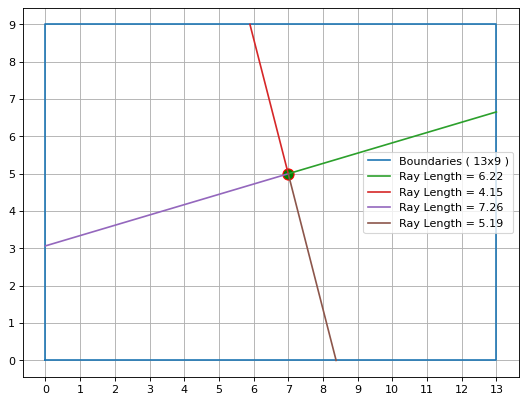

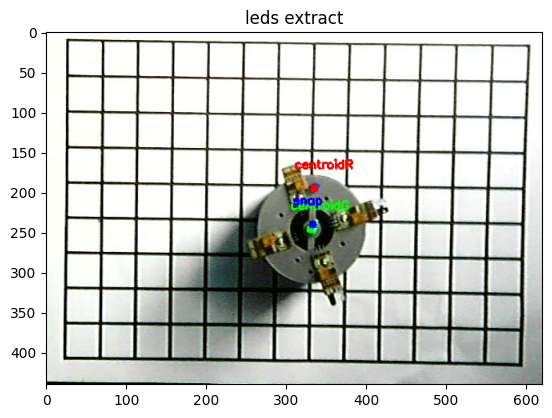

In [467]:


# x,y = grid.boundaries.exterior.xy
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(*grid.boundaries.xy, label="Boundaries ( "+ str(grid.x_max) +"x"+ str(grid.y_max) +" )")
plt.plot(*spiderino.pos.xy, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
for sensor in spiderino.sensors_array :
  plt.plot(*sensor.ray.xy, label="Ray Length = "+str(round((sensor.ray.length),2)))

leg = plt.legend()
ax.set_xticks(np.arange(0,grid.x_max+1))
ax.set_yticks(np.arange(0,grid.y_max+1))
plt.grid(True)

plt.show()
imgee = imge.copy()
cv2.circle(imgee, (points_matrix[x_snap][y_snap]), 5, (0, 0,255), -1)
cv2.putText(imgee, "snap", (points_matrix[x_snap][y_snap][0] - 25, points_matrix[x_snap][y_snap][1] - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
nb_show("leds extract",imgee)

In [424]:
print(spiderino.sensors_array[0].angle)

15.5
